### Notebook Preperation

Getting Pyspark and the data file

In [1]:
%%bash
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=nba_all_seasons.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/ayyappabhuma/NBA-player-anlaysis-with-Pyspark/main/nba_all_seasons.csv &> /dev/null
fi

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import functions as fn
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, DateType, StringType

from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import Tokenizer, CountVectorizer, VectorAssembler


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Used only for visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [3]:
#Grid Search for any hyper parameter tuning
enable_grid_search = False

### Data Preperation

#### Importing the data as a spark dataframe

In [4]:
all_seasons_df = spark.read.csv("nba_all_seasons.csv", inferSchema = True, header = True)
display(all_seasons_df.show())

+---+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------+
|_c0|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct| season|
+---+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------+
|  0|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Southeastern Okla...|    USA|      1986|          2|          27| 55| 5.

None

In [5]:
print("Shape of the dataframe is: ")
print("No. of Rows: ", all_seasons_df.count())
print("No. of Columns: ", len(all_seasons_df.columns))
print("Data Schema:")
display(all_seasons_df.printSchema())

Shape of the dataframe is: 
No. of Rows:  12305
No. of Columns:  22
Data Schema:
root
 |-- _c0: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- team_abbreviation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- college: string (nullable = true)
 |-- country: string (nullable = true)
 |-- draft_year: string (nullable = true)
 |-- draft_round: string (nullable = true)
 |-- draft_number: string (nullable = true)
 |-- gp: integer (nullable = true)
 |-- pts: double (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- net_rating: double (nullable = true)
 |-- oreb_pct: double (nullable = true)
 |-- dreb_pct: double (nullable = true)
 |-- usg_pct: double (nullable = true)
 |-- ts_pct: double (nullable = true)
 |-- ast_pct: double (nullable = true)
 |-- season: string (nullable = true)



None

#### Checking for missing values

In [6]:
all_seasons_df.select([fn.count(fn.when(fn.isnan(c) | fn.col(c).isNull(), c)).alias(c) for c in all_seasons_df.columns]).show()

+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+
|_c0|player_name|team_abbreviation|age|player_height|player_weight|college|country|draft_year|draft_round|draft_number| gp|pts|reb|ast|net_rating|oreb_pct|dreb_pct|usg_pct|ts_pct|ast_pct|season|
+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+
|  0|          0|                0|  0|            0|            0|      0|      0|         0|          0|           0|  0|  0|  0|  0|         0|       0|       0|      0|     0|      0|     0|
+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+



No values are missing in the data set

#### Fixing Schema

In [7]:
# Converting variable "season" to date type
all_seasons_df = all_seasons_df.withColumn('season', all_seasons_df.season.substr(1,4)) #taking only season start year
all_seasons_df = all_seasons_df.withColumn("season", all_seasons_df["season"].cast(DateType()))

In [8]:
#Replacing "undrafted" with 0 to convert to integer type
all_seasons_df = all_seasons_df.withColumn('draft_year', fn.when(all_seasons_df.draft_year == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_year))
all_seasons_df = all_seasons_df.withColumn('draft_round', fn.when(all_seasons_df.draft_round == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_round))
all_seasons_df = all_seasons_df.withColumn('draft_number', fn.when(all_seasons_df.draft_number == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_number))

In [9]:
# dropping column "_c0"(serial number) as it is not needed
all_seasons_df = all_seasons_df.drop('_c0')

In [10]:
#Fixing variable types
all_seasons_df = all_seasons_df.withColumn("draft_year", all_seasons_df["draft_year"].cast(IntegerType()))
all_seasons_df = all_seasons_df.withColumn("draft_round", all_seasons_df["draft_round"].cast(IntegerType()))
all_seasons_df = all_seasons_df.withColumn("draft_number", all_seasons_df["draft_number"].cast(IntegerType()))

In [11]:
#Final Data Frame
print("New shape of our dataframe is: ")
print("No. of Rows: ", all_seasons_df.count())
print("No. of Columns: ", len(all_seasons_df.columns))
display(all_seasons_df.show())
print("Data Schema:")
all_seasons_df.printSchema()

New shape of our dataframe is: 
No. of Rows:  12305
No. of Columns:  21
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+
|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|    season|
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+
|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Southea

None

Data Schema:
root
 |-- player_name: string (nullable = true)
 |-- team_abbreviation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- college: string (nullable = true)
 |-- country: string (nullable = true)
 |-- draft_year: integer (nullable = true)
 |-- draft_round: integer (nullable = true)
 |-- draft_number: integer (nullable = true)
 |-- gp: integer (nullable = true)
 |-- pts: double (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- net_rating: double (nullable = true)
 |-- oreb_pct: double (nullable = true)
 |-- dreb_pct: double (nullable = true)
 |-- usg_pct: double (nullable = true)
 |-- ts_pct: double (nullable = true)
 |-- ast_pct: double (nullable = true)
 |-- season: date (nullable = true)



#### Summary Statistics

In [12]:
#Statistics of Numeric Variables
all_seasons_df.select("age", "player_height", "player_weight", "draft_round", "gp", "pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct") \
                .summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|summary|              age|     player_height|     player_weight|       draft_round|                gp|              pts|               reb|               ast|         net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|  count|            12305|             12305|             12305|             12305|             12305|            12305|             12305|             1230

### Data Exploration

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


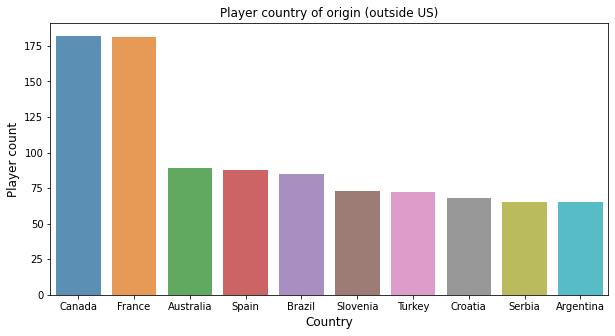

In [13]:
# Player country of origin distribution (outside US)
country_count  = all_seasons_df.filter(all_seasons_df.country != "USA").toPandas()["country"].value_counts()
country_count = country_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title('Player country of origin (outside US)')
plt.ylabel('Player count', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

Outside of the United States, major players come from Canada and France. There are players belonging from other countries as well such as Brazil, Australia, Spain, Slovenia, Turkey, Croatia, Argentia

In [14]:
# fig = px.histogram(all_seasons_df.groupby(['season', 'pts']).mean().toPandas(), x="season", y="avg(pts)", color="season")
# fig.show()

Text(0.5, 1.0, 'Avg points scored v/s Season')

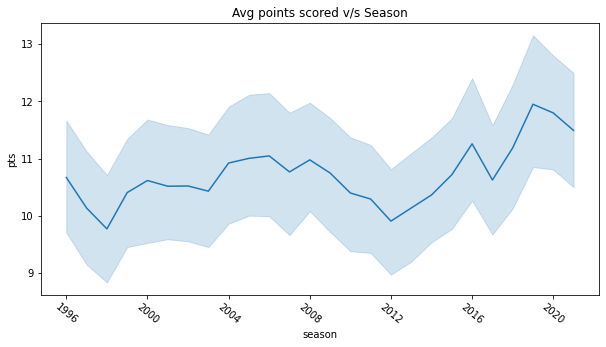

In [15]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=-40)
sns.lineplot(data=all_seasons_df.groupby(['season','pts']).mean().toPandas(), x="season", y="pts")
plt.title('Avg points scored v/s Season')

We see that as the seasons have passed, we see that the points scored by the players have increased drastically. Change in their game staretgy might be on the reasons for the improvement.

Text(0.5, 1.0, 'Season v/s age')

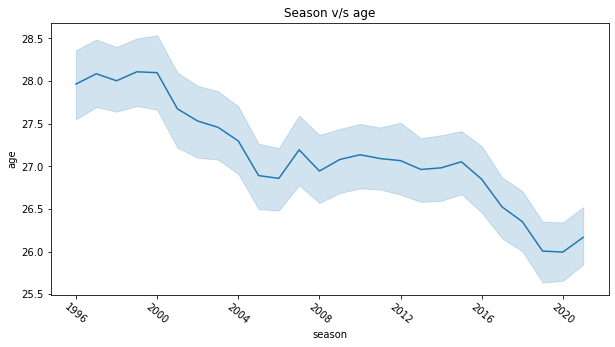

In [16]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=-40)
sns.lineplot(data=all_seasons_df.toPandas(), x="season", y="age")
plt.title('Season v/s age')

We see that as the seasons have passed, the age of the players have reduced considerably. Younger players might be one of the reasons for the team to score maximum points

In [17]:
fig = px.histogram(all_seasons_df.toPandas(), x="season", y=["pts", "ast", "reb"], barmode = "group")
fig.show()

We see that even though the points have increased over the time, the assists distributed seem to be distributed with a slight increase in the number of rebounds grabbed.

In [18]:
fig = px.histogram(all_seasons_df.toPandas(), x="season", y=["oreb_pct", "dreb_pct", "usg_pct","ts_pct"], barmode = "group")
fig.show()

We see that shooting efficiency of the players (2 and 3 point shots) have increased considerably over these 10 years. There is an overall slight increase in the percentage of team plays and the percentage of available defensive rebounds player grabbed.

Height and Weight Analysis

In [19]:
#Selecting the columns to observe the distributions of height and weight
#grouping data of each player to work on average values
physical_stats_df = all_seasons_df.groupBy("player_name") \
                                  .agg(fn.mean("player_weight").alias("player_weight"), \
                                    fn.mean("player_height").alias("player_height"))

physical_stats_df.show()

+----------------+------------------+------------------+
|     player_name|     player_weight|     player_height|
+----------------+------------------+------------------+
|   Reggie Miller| 86.78726933333331|200.66000000000003|
|     Terry Mills|109.76926399999999|208.28000000000003|
|  Rodney Stuckey| 92.98635999999999|195.57999999999998|
| Al-Farouq Aminu| 98.55317090909092|205.27818181818182|
|   Greg Stiemsma|         117.93392|            210.82|
|  Brandon Ingram|          86.18248|204.04666666666665|
|     Tyler Lydon|100.92421999999999|            207.01|
|  Svi Mykhailiuk| 92.98635999999999|           201.295|
|Lonnie Walker IV|         92.646166|            194.31|
|   Nassir Little|          99.79024|            195.58|
|   Eric Williams| 99.79024000000003|203.20000000000002|
|    Bobby Phills|        100.017036|            195.58|
|    Carl Herrera|          102.0582|            205.74|
|Shandon Anderson|        95.3903976|198.11999999999998|
|  Terry Cummings|109.996059999

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



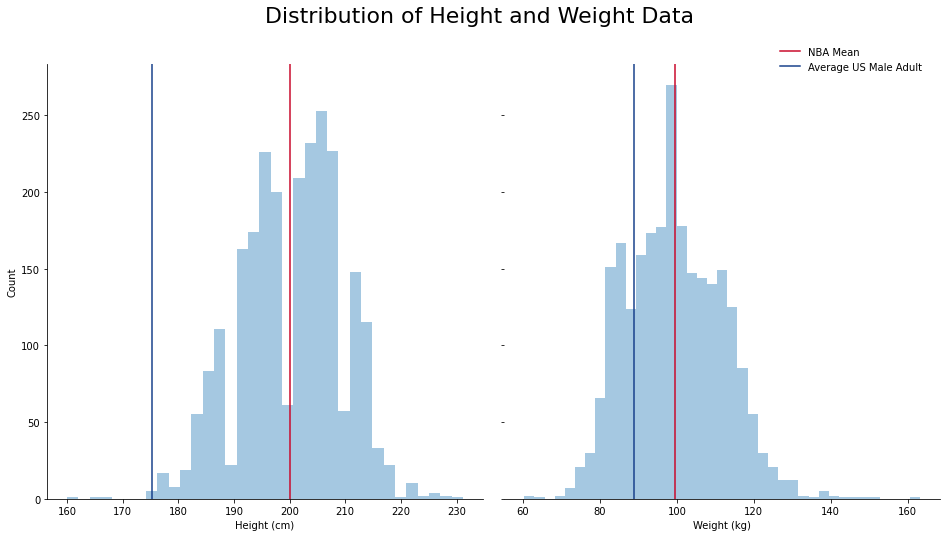

In [20]:
#Histograms of height and weight distribution
fig, ax = plt.subplots(1,2,figsize=(16, 8),sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.distplot(physical_stats_df.toPandas() ['player_height'], ax=ax[0], label='_nolegend_', kde=False)
sns.distplot(physical_stats_df.toPandas() ['player_weight'], ax=ax[1], label='_nolegend_', kde=False)
ax[0].axvline(physical_stats_df.toPandas() ['player_height'].mean(), color='#c9082a', label='NBA Mean')
ax[1].axvline(physical_stats_df.toPandas() ['player_weight'].mean(), color='#c9082a', label='NBA Mean')

ax[0].axvline(175.3, color='#17408b', label='Average US Male Adult') # Average height of US Male adult (cm)
ax[1].axvline(88.8, color='#17408b', label='Average US Male Adult') # Average weight of US Male adult (kg)

ax[0].yaxis.set_label_text('Count')
ax[0].xaxis.set_label_text('Height (cm)')
ax[1].xaxis.set_label_text('Weight (kg)')
plt.suptitle('Distribution of Height and Weight Data', fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(0.98, 1.06), frameon=False)
sns.despine(ax=ax[1], left=True)
sns.despine(ax=ax[0])

plt.show()

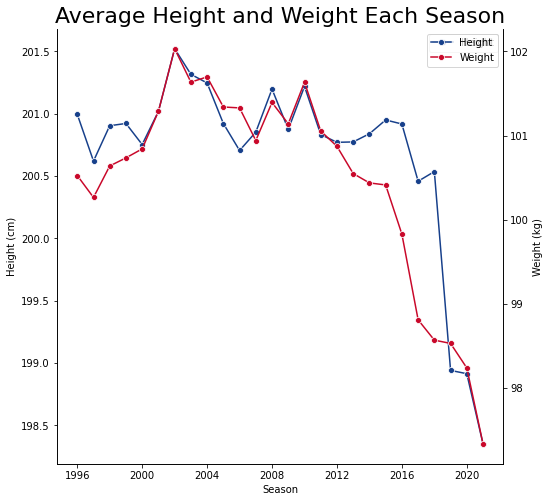

In [21]:
# line plot to observe change in average height and weight across season
fig, ax = plt.subplots(figsize=(8, 8))
ax2 = ax.twinx()

sns.lineplot(x=all_seasons_df.toPandas()['season'], y='player_height', data=all_seasons_df.toPandas(), marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=all_seasons_df.toPandas()['season'], y='player_weight', data=all_seasons_df.toPandas(), marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight Each Season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

We can say a steady decrease in average height and weight of players

Height and Weight based on Draft Year

Observing average height and weight of players playing their first season

In [22]:
#filtering dataframe to get statistics of player's drafted year
updated_df = all_seasons_df.filter(all_seasons_df.draft_year > 0)

updated_df = updated_df.withColumn("draft_year", updated_df["draft_year"].cast(StringType()))
updated_df = updated_df.withColumn("draft_year", updated_df["draft_year"].cast(DateType()))

updated_df = updated_df.filter(updated_df.season == updated_df.draft_year)

In [23]:
#Player-wise height and weight in their first season
hw_stats_draft_year = updated_df.groupBy("player_name") \
                                  .agg(fn.mean("player_weight").alias("player_weight"), \
                                    fn.mean("player_height").alias("player_height"))

hw_stats_draft_year.show()

+--------------------+------------------+-------------+
|         player_name|     player_weight|player_height|
+--------------------+------------------+-------------+
|      Rodney Stuckey| 92.98635999999999|       195.58|
|     Al-Farouq Aminu| 97.52228000000001|       205.74|
|      Brandon Ingram|          86.18248|       205.74|
|         Tyler Lydon|          99.79024|       205.74|
|      Svi Mykhailiuk| 92.98635999999999|        203.2|
|    Lonnie Walker IV| 92.98635999999999|       195.58|
|       Nassir Little|          99.79024|       195.58|
|    Shandon Anderson| 94.34713599999999|       198.12|
|        Andre Miller|         92.079176|       187.96|
|      Marcus Haislip|         104.32616|       208.28|
|      Viktor Khryapa|          95.25432|       205.74|
|      Kevin Seraphin|          124.7378|       205.74|
|         Zach LaVine|         83.007336|       195.58|
|    Jarrell Brantley|           113.398|       195.58|
|      Korleone Young|         96.615096|       

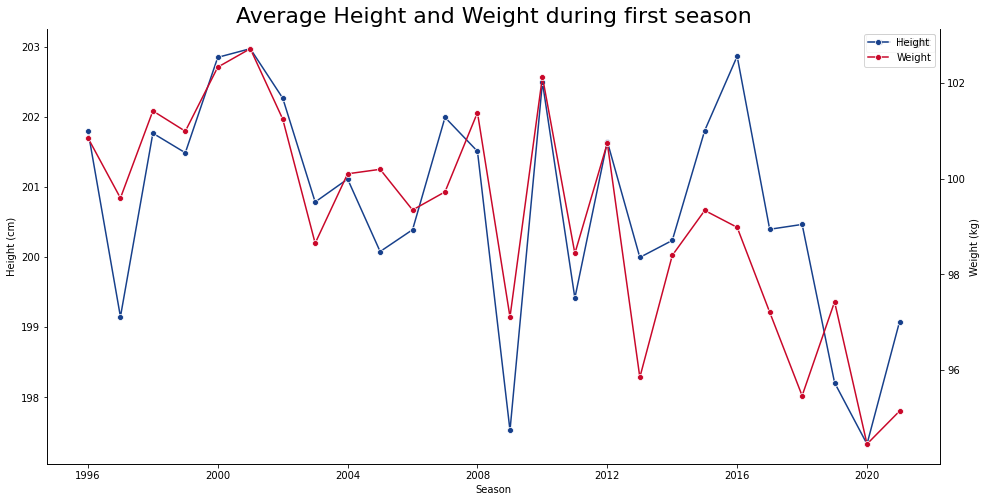

In [24]:
# line plot to observe change in height and weight of player's playing their first season
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=updated_df.toPandas()['season'], y='player_height', data=updated_df.toPandas(), marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=updated_df.toPandas()['season'], y='player_weight', data=updated_df.toPandas(), marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight during first season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

No steady decrease is observed but there is a decrease in avg height and weight of players getiing drafted

Heat Map for analysing correlation

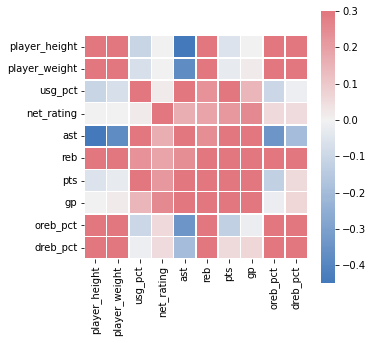

In [25]:
# heat map to observe correlation of physical statistics to performance statistics
cor_df = all_seasons_df.select('player_height', 'player_weight', 'usg_pct', 'net_rating', 'ast', 'reb', 'pts', 'gp', 'oreb_pct', 'dreb_pct')
corr = cor_df.toPandas().corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

plt.show()

No correlation between physical statistics and net rating or points scored but as height and weight increase, rebounds count increased and assists count decreased

### Modelling

#### Classifying if a player is offensive

The "ts_pct" column gives : Measure of the player's shooting efficiency that takes into account free throws, 2 and 3 point shots (PTS / (2*(FGA + 0.44 * FTA)))



In [26]:
all_seasons_df.select(fn.mean("ts_pct")).show()

+------------------+
|       avg(ts_pct)|
+------------------+
|0.5110600568874436|
+------------------+



Mean of "ts_pct" is 0.51. Taking this as threshold value, adding a binary variable "offensive" that specifies if a player is offensive 

In [27]:
threshold= 0.51

def offensive_player(ts_pct):
    if ts_pct >= threshold:
      return '1'
    else:
      return '0'

off = fn.udf(lambda ts_pct: offensive_player(ts_pct))
offensive_player_df = all_seasons_df.withColumn('offensive', off(fn.col('ts_pct')))
offensive_player_df = offensive_player_df.withColumn("offensive", offensive_player_df["offensive"].cast(IntegerType()))

display(offensive_player_df.show())

+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+---------+
|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|    season|offensive|
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+---------+
|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Southeastern Okla...|    USA|      1986|         

None

Using logistic regression to create a classification model that determines whether a player is offensive based on his offensive statistics.

In [28]:
# train-test split
train, validation, test = offensive_player_df.randomSplit([0.7, 0.2, 0.1])

In [29]:
# grid search to find optimal alpha and lambda of regularization (parameters)
va = VectorAssembler(inputCols= ['oreb_pct','ast_pct','pts','ast'], outputCol= 'offense_features')
lr = LogisticRegression(featuresCol= 'offense_features', labelCol= 'offensive')
lr_pipe = Pipeline(stages= [va, lr])

if enable_grid_search:
  grid = paramGrid = ParamGridBuilder().\
      addGrid(lr.elasticNetParam, [0., 0.01, 0.1]).\
      addGrid(lr.regParam, [0.1, 0.01, 0.001]).\
      build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_pipe.fit(train, grid[j])
      all_models.append(model)

  
  crossval = CrossValidator(estimator= lr_pipe, 
                          estimatorParamMaps= paramGrid, 
                          evaluator= BinaryClassificationEvaluator(), 
                          numFolds= 3)
    
  accuracies = [m.\
      transform(validation).\
      select(fn.avg(fn.expr('float(offensive = prediction)')).alias('accuracy')).\
      first().\
      accuracy for m in all_models]
  accuracies
  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  print("best model accuracy =", accuracies[best_model_idx])
  display(grid[best_model_idx])

pass

In [30]:
#Logistic Regression model with optimal parameters
alpha_par = 0.1
lambda_par = 0.001

en_lr = LogisticRegression().\
        setLabelCol('offensive').\
        setFeaturesCol('offense_features').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

lr_pipe = Pipeline(stages=[va,en_lr])
lr_model = lr_pipe.fit(train)

In [31]:
#testing the model on test data
best_offensive_player_df = lr_model.transform(test)

eval_auc = BinaryClassificationEvaluator(labelCol='offensive', rawPredictionCol= 'prediction', metricName= 'areaUnderROC')
AUC_best = eval_auc.evaluate(best_offensive_player_df)
print("AUC for optimized model is : ", AUC_best)

AUC for optimized model is :  0.7177087311658392


#### Clustering to see effect of physical characterestics on performance

In [32]:
#Preparing data for clustering by selecting required columns
clustering_df = all_seasons_df.select('player_height', 'player_weight', 'pts', 'reb', 'ast', 'net_rating')
clustering_df.show()

+-------------+------------------+----+----+---+----------+
|player_height|     player_weight| pts| reb|ast|net_rating|
+-------------+------------------+----+----+---+----------+
|       198.12|          99.79024| 5.7|16.1|3.1|      16.1|
|        215.9|         117.93392| 2.3| 1.5|0.3|      12.3|
|       205.74|          95.25432| 0.8| 1.0|0.4|      -2.1|
|        203.2|        100.697424| 3.7| 2.3|0.6|      -8.7|
|       205.74|         108.86208| 2.4| 2.4|0.2|     -11.2|
|       200.66| 97.52228000000001| 8.2| 2.7|1.0|       4.1|
|       198.12|          86.18248|17.2| 4.1|3.4|       4.1|
|       213.36|           113.398|14.9| 8.0|1.6|       3.3|
|       193.04|          86.18248| 5.7| 1.6|1.3|      -0.3|
|       182.88|          72.57472| 6.9| 1.5|3.0|      -1.2|
|       182.88|          77.11064| 2.4| 0.4|1.2|      -7.4|
|       213.36|122.46983999999999| 0.0| 0.0|0.0|    -147.5|
|       195.58|         87.996848| 5.0| 1.7|2.0|       6.6|
|        190.5| 80.28578399999998| 1.3| 

In [33]:
#Features column for pipeline
assembler = feature.VectorAssembler(inputCols=['player_height', 'player_weight', 'pts', 'reb', 'ast', 'net_rating'], outputCol='features')
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

Kmeans Clustering of data

In [34]:
#Finding optimal K from silhouette score
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='centered_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
if enable_grid_search == True:
  for i in range(2,10):   
      KMeans_algo=KMeans(featuresCol='centered_features', k=i)

      cluster_pipe = Pipeline(stages = [assembler,
                                        center,
                                        KMeans_algo        
                                          ])
      
      KMeans_fit=cluster_pipe.fit(clustering_df)
      output=KMeans_fit.transform(clustering_df)
          
      score=evaluator.evaluate(output)    
      silhouette_score.append(score)
      print("Silhouette Score:",score)

In [35]:
#line plot to decide on optimal k
if enable_grid_search == True:
  fig, ax = plt.subplots(1,1, figsize =(8,6))
  ax.plot(range(2,10),silhouette_score)
  ax.set_xlabel('k')
  ax.set_ylabel('cost')

From the plot local maxima appears to occur at k = 4, so, performing clustering with k = 4

In [36]:
#Final clustering Model
kmeans_4 = KMeans(featuresCol='centered_features', k=4)
cluster_pipe = Pipeline(stages = [assembler, center, kmeans_4])

KMeans_fit = cluster_pipe.fit(clustering_df)
clustering_output = KMeans_fit.transform(clustering_df)

clustering_output.show()

+-------------+------------------+----+----+---+----------+--------------------+--------------------+----------+
|player_height|     player_weight| pts| reb|ast|net_rating|            features|   centered_features|prediction|
+-------------+------------------+----+----+---+----------+--------------------+--------------------+----------+
|       198.12|          99.79024| 5.7|16.1|3.1|      16.1|[198.12,99.79024,...|[-2.4916017878906...|         1|
|        215.9|         117.93392| 2.3| 1.5|0.3|      12.3|[215.9,117.93392,...|[15.2883982121093...|         0|
|       205.74|          95.25432| 0.8| 1.0|0.4|      -2.1|[205.74,95.25432,...|[5.12839821210931...|         1|
|        203.2|        100.697424| 3.7| 2.3|0.6|      -8.7|[203.2,100.697424...|[2.58839821210929...|         1|
|       205.74|         108.86208| 2.4| 2.4|0.2|     -11.2|[205.74,108.86208...|[5.12839821210931...|         0|
|       200.66| 97.52228000000001| 8.2| 2.7|1.0|       4.1|[200.66,97.522280...|[0.0483982121093

Checking the clusters height and weight distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



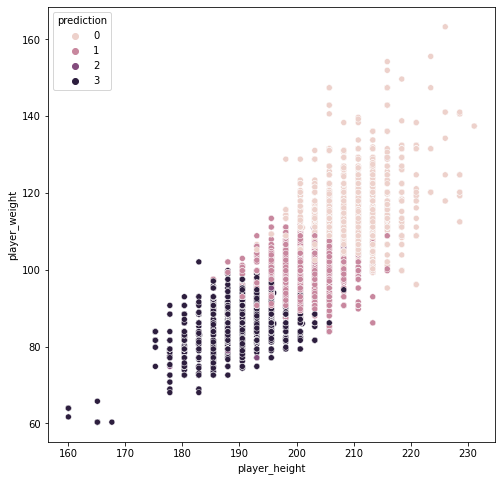

In [37]:
# Height and weight of players in each cluster
output = clustering_output.toPandas()

plt.figure(figsize=(8, 8))
sns.scatterplot('player_height', 'player_weight', data=output, hue='prediction')

plt.show()

As expected from physical stats data, clusters are divided by height and weight of players

In [38]:
#summary statistics of clusters
clustering_output.groupBy('prediction').agg(fn.mean("player_height"), fn.mean("player_weight"), fn.mean("pts"), fn.mean("net_rating"), fn.mean("reb"), fn.mean("ast"), fn.count("*")).show()

+----------+------------------+------------------+------------------+-------------------+------------------+------------------+--------+
|prediction|avg(player_height)|avg(player_weight)|          avg(pts)|    avg(net_rating)|          avg(reb)|          avg(ast)|count(1)|
+----------+------------------+------------------+------------------+-------------------+------------------+------------------+--------+
|         1| 200.9183802663142| 99.02187634141102| 9.096987557301913| 0.6393363894346225| 3.540340537000646|1.7437677363021187|    4581|
|         3|   189.63710975963|  85.8839461754987| 8.018940052128572|-4.7119026933101535|2.1168838690993366| 2.888618592528237|    3453|
|         2|200.86054054054048|  97.6903948108108|1.8270270270270268|  85.16216216216216|0.7486486486486488|0.3054054054054054|      37|
|         0|209.22765233821053|113.66578067831819| 7.353731695795921| -4.148889938592343| 4.780302314596118|1.0267359470949449|    4234|
+----------+------------------+----------

The players with low stats form one cluster.
As average height and average weight increase, we see a decrease in the average assist count and an increase in the average rebound count for other clusters. This matches what the correlation plot indicated.

#### Predicting Net Rating of a player

The "net_rating" variable gives - Team's point differential per 100 possessions while the player is on the court. This is a good indicator of performance of a player

Regression model to predict net_rating of a player from his statistics

In [39]:
#preparing data by selecting required columns
rating_df = all_seasons_df.select('team_abbreviation', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct')

print("Shape of our dataframe is: ")
print("No. of Rows: ", rating_df.count())
print("No. of Columns: ", len(rating_df.columns))
display(rating_df.show())

Shape of our dataframe is: 
No. of Rows:  12305
No. of Columns:  14
+-----------------+----+-------------+------------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+
|team_abbreviation| age|player_height|     player_weight| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|
+-----------------+----+-------------+------------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+
|              CHI|36.0|       198.12|          99.79024| 55| 5.7|16.1|3.1|      16.1| 0.18600000000000003|0.32299999999999995|                0.1|              0.479|              0.113|
|              LAC|28.0|        215.9|         117.93392| 15| 2.3| 1.5|0.3|      12.3|               0.078|              0.151|              0.175|               0.43|             

None

In [40]:
#train-test split
train_df, test_df, valid_df = rating_df.randomSplit([0.7,0.2,0.1])

In [41]:
#pipeline to encode category variable "team_abbreviation"
team_pipe =Pipeline(stages = [feature.StringIndexer(inputCol='team_abbreviation', outputCol='indexed_team')])

#features column
va = VectorAssembler(inputCols= ['indexed_team', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'], outputCol='features')

#standard scalar of features
std = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

Using Linear Regressor

In [42]:
#hyper-patamer tuning with grid search
lr = regression.LinearRegression(featuresCol='centered_features', labelCol = 'net_rating')
evaluator = RegressionEvaluator(labelCol= 'net_rating', metricName='mse')
lr_pipe = Pipeline(stages=[team_pipe, va, std, lr])

if enable_grid_search == True:
  lrparamGrid = ParamGridBuilder()\
              .addGrid(lr.regParam, [0.1, 0.01]) \
              .addGrid(lr.fitIntercept, [False, True])\
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
              .build()

  lrcrossval = CrossValidator(estimator= lr_pipe,
                            estimatorParamMaps=lrparamGrid,
                            evaluator= evaluator,
                            numFolds=3)

  lrcvModel = lrcrossval.fit(train_df)

  lrpredictions = lrcvModel.transform(valid_df)
  lr_mse = evaluator.evaluate(lrpredictions)

  lrbestPipeline = lrcvModel.bestModel
  lrbestModel = lrbestPipeline.stages[-1]

  print('Best reg Param - ', lrbestModel.getOrDefault('regParam'))
  print('Best fit intercept - ', lrbestModel.getOrDefault('fitIntercept'))
  print('Elastic Net Param -',lrbestModel.getOrDefault('elasticNetParam'))
  print('MSE -', lr_mse)

In [43]:
#optimal linear model
new_lr = regression.LinearRegression(featuresCol='centered_features', labelCol='net_rating', regParam= 0.1, fitIntercept= False, elasticNetParam = 0.5)
best_lr_pipe = Pipeline(stages=[team_pipe, va, std, new_lr])
lr_best_model = best_lr_pipe.fit(train_df)

In [44]:
#Testing linear model
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="net_rating", metricName="mse")
lr_train_mse = lr_evaluator.evaluate(lr_best_model.transform(train_df))
lr_test_mse = lr_evaluator.evaluate(lr_best_model.transform(test_df))
print("Linear Regression results:")
print('Train MSE:', lr_train_mse)
print('Test MSE:', lr_test_mse)

Linear Regression results:
Train MSE: 143.36251578298175
Test MSE: 137.87964920113666


Using Random Forest Regressor

In [45]:
#hyper-patamer tuning with grid search
rf_rating = RandomForestRegressor(labelCol = 'net_rating', featuresCol='centered_features')
rf_rating_pipe = Pipeline(stages=[team_pipe, va, std, rf_rating])

if enable_grid_search:
  grid = paramGrid = ParamGridBuilder().\
      addGrid(rf_rating.maxDepth, [2, 5, 10]).\
      addGrid(rf_rating.maxBins, [5, 10, 20]).\
      addGrid(rf_rating.numTrees, [5, 20, 50]).\
      build()
  grid
  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = rf_rating_pipe.fit(train_df,grid[j])
    all_models.append(model)

  crossval = CrossValidator(estimator=rf_rating_pipe,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)
  mse = [m.transform(valid_df).select(fn.mean((fn.col('net_rating') - fn.col('prediction'))**2).alias('mse')).first().mse for m in all_models]
  mse
  best_model_idx = np.argmin(mse)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  print("best model mse =", mse[best_model_idx])
  display(grid[best_model_idx])
pass

In [46]:
#optimal Random Forest regression Model
best_rf_rating = RandomForestRegressor(labelCol = 'net_rating', featuresCol='centered_features', numTrees=10, maxDepth=5,maxBins=5)
best_rf_pipe = Pipeline(stages=[team_pipe, va, std, best_rf_rating])
best_rf_model = best_rf_pipe.fit(train_df)

In [47]:
#Testing the optimal model
rf_train_mse = lr_evaluator.evaluate(best_rf_model.transform(train_df))
rf_test_mse = lr_evaluator.evaluate(best_rf_model.transform(test_df))
print("Random Forest Regression results:")
print('Train MSE:', rf_train_mse)
print('Test MSE:', rf_test_mse)

Random Forest Regression results:
Train MSE: 135.93747446774125
Test MSE: 133.2038129187597


In [48]:
#printing net_rating statistics to evaluate the performance of models
all_seasons_df.select("net_rating").summary().show()

+-------+-------------------+
|summary|         net_rating|
+-------+-------------------+
|  count|              12305|
|   mean|-2.2557334416903685|
| stddev| 12.673254189413505|
|    min|             -250.0|
|    25%|               -6.4|
|    50%|               -1.3|
|    75%|                3.2|
|    max|              300.0|
+-------+-------------------+



As net_rating ranging from -250 to 300. The resulting mean square error on test data shows that both models performed good and nearly equally well

Feature Importance of variables in predicting net rating (across different seasons)

In [49]:
#Initiating empty pandas dataframe to collect feature importance values
feature_importance_df = pd.DataFrame(columns=['feature', 'importance', 'season']) 
#list of features
feature_list = ['indexed_team', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']

#season wise random forest models to get feature importance values
for row in all_seasons_df.select('season').distinct().collect():
  rating_df = all_seasons_df.filter(all_seasons_df.season == row.season).select('team_abbreviation', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct')
  
  rf_rating = RandomForestRegressor(labelCol = 'net_rating', featuresCol='centered_features', numTrees=20, maxDepth=5,maxBins=20)
  rf_rating_pipe_model = Pipeline(stages=[team_pipe, va, std, rf_rating]).fit(rating_df) #using entire rating data as we just need the feature importance values

  coefficient_list = list(rf_rating_pipe_model.stages[-1].featureImportances.toArray()) #getting feature importance values
  rf_feature_importance = pd.DataFrame({'feature': feature_list, 'importance': coefficient_list}).sort_values('importance', ascending=False)
  rf_feature_importance["season"] = row.season

  feature_importance_df = feature_importance_df.append(rf_feature_importance, ignore_index=True)

print(feature_importance_df)

           feature  importance      season
0           ts_pct    0.236074  2009-01-01
1     indexed_team    0.151038  2009-01-01
2               gp    0.118934  2009-01-01
3              ast    0.071685  2009-01-01
4              reb    0.065761  2009-01-01
..             ...         ...         ...
333            reb    0.056475  2014-01-01
334            pts    0.053685  2014-01-01
335        usg_pct    0.043900  2014-01-01
336        ast_pct    0.023030  2014-01-01
337  player_weight    0.021513  2014-01-01

[338 rows x 3 columns]


Analysing the change in feature importance of variables

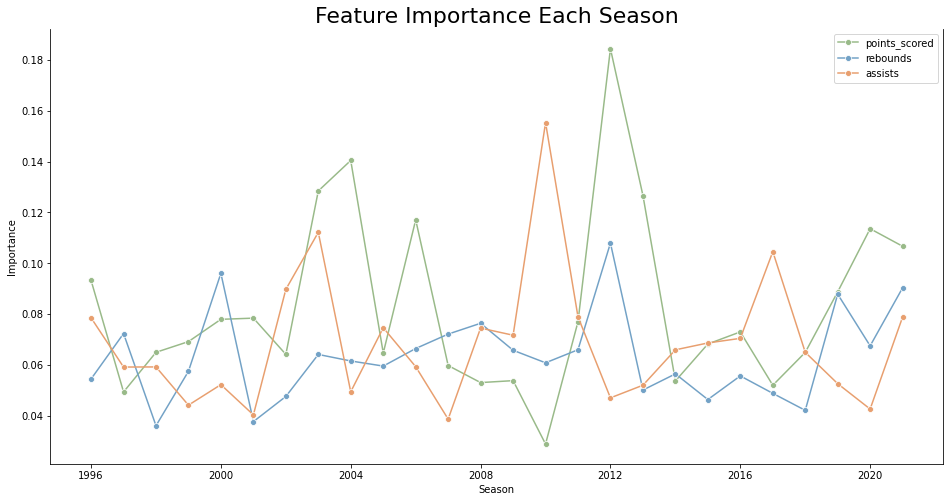

In [50]:
#feature importances of "points", "assists" and "rebounds"
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(x=feature_importance_df[feature_importance_df['feature'] == 'pts']['season'], y='importance', data=feature_importance_df[feature_importance_df['feature'] == 'pts'], marker="o", ax=ax, ci=None, label='points_scored', color='#99ba89')
sns.lineplot(x=feature_importance_df[feature_importance_df['feature'] == 'reb']['season'], y='importance', data=feature_importance_df[feature_importance_df['feature'] == 'reb'], marker="o", ax=ax, ci=None, label='rebounds', color='#73a2c6')
sns.lineplot(x=feature_importance_df[feature_importance_df['feature'] == 'ast']['season'], y='importance', data=feature_importance_df[feature_importance_df['feature'] == 'ast'], marker="o", ax=ax, ci=None, label='assists', color='#e89f6f')

plt.title('Feature Importance Each Season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Importance')

lines, labels = ax.get_legend_handles_labels()
ax.spines['top'].set_visible(False)

plt.show()

Although the importance of any variable did not continuously increase or decrease, plot suggests that no variable is always important for all seasons

Draft-Round Prediction

In [51]:
all_season = all_seasons_df[all_seasons_df['draft_number'] != 0]
draft_pred = all_season.select('draft_round', 'pts', 'player_height','player_weight','reb','gp')
draft_pred = draft_pred[draft_pred['draft_round'] <= 2]

In [52]:
training_df, validate_df, testing_df = draft_pred.randomSplit([0.7,0.2,0.1])

In [53]:
va_assembler = VectorAssembler(inputCols= ['pts', 'player_height','player_weight','reb','gp'], outputCol='round')
std = feature.StandardScaler(withMean=True, withStd=False, inputCol='round', outputCol='centered_round')

In [54]:
lr_draft = LogisticRegression(labelCol = 'draft_round', featuresCol='centered_round')
lr_draft_pipeline = Pipeline(stages=[va_assembler, std, lr_draft])

if enable_grid_search:
  grid = paramGrid = ParamGridBuilder().\
      addGrid(lr_draft.elasticNetParam, [0., 0.01, 0.1]).\
      addGrid(lr_draft.regParam, [0.1, 0.01, 0.001]).\
      build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_draft_pipeline.fit(train_df, grid[j])
      all_models.append(model)
  
  crossval = CrossValidator(estimator= lr_draft_pipeline, 
                          estimatorParamMaps= paramGrid, 
                          evaluator= BinaryClassificationEvaluator(), 
                          numFolds= 3)   
  accuracies = [m.\
      transform(validate_df).\
      select(fn.avg(fn.expr('float(draft_round = prediction)')).alias('accuracy')).\
      first().\
      accuracy for m in all_models]
  accuracies
  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  print("best model accuracy =", accuracies[best_model_idx])
  display(grid[best_model_idx])
pass

In [55]:
# alpha_par1 = 0.1
# lambda_par1 = 0.001

# draft_lr = LogisticRegression().\
#         setLabelCol('draft_round').\
#         setFeaturesCol('centered_round').\
#         setRegParam(lambda_par1).\
#         setMaxIter(100).\
#         setElasticNetParam(alpha_par1)

# draft_best = Pipeline(stages=[va_assembler, std, draft_lr]).fit(train_df)
# best_draft_df = draft_best.transform(test_df)

In [56]:
# best_draft_df.select(fn.avg(fn.expr('float(draft_round = prediction)')).alias('accuracy')).show()

In [57]:
# best_draft_df.select('draft_round','prediction').show(30)